# Cyberbullying Classification
## 47k tweets belonging to 6 balanced classes.
As social media usage becomes increasingly prevalent in every age group, a vast majority of citizens rely on this essential medium for day-to-day communication. Social media’s ubiquity means that cyberbullying can effectively impact anyone at any time or anywhere, and the relative anonymity
of the internet makes such personal attacks more difficult to stop than traditional bullying.

On April 15th, 2020, UNICEF issued a warning in response to the increased risk of cyberbullying during the COVID-19 pandemic due to widespread school closures, increased screen time, and decreased face-to-face social interaction. The statistics of cyberbullying are outright alarming: 36.5% of middle and high school students have felt cyberbullied and 87% have observed cyberbullying, with effects ranging from decreased academic performance to depression to suicidal thoughts.

In light of all of this, this dataset contains more than 47000 tweets labelled according to the class of cyberbullying:

Age;
Ethnicity;
Gender;
Religion;
Other type of cyberbullying;
Not cyberbullying
The data has been balanced in order to contain ~8000 of each class.

Trigger Warning These tweets either describe a bullying event or are the offense themselves, therefore explore it to the point where you feel comfortable.

## Ideas
1. Establish if boys are more prone to intimidation than girls
2. Create a multiclassification model to predict cyberbullying type;
3. Create a binary classification model to flag potentially harmful tweets;
4. Explore words and patterns associated with each type of cyberbullying.

### Prof ideas Vertical vs Horizontal approach 
1. Interpretability/explainability 
    - For example finding the features that are most significant per sentiment 
    - Create world clouds to see the words associated with it
    - Embeddings visualization 
2. Unsupervised sentiment analysis
    - Compare different sentiment in the class itsefl
        - Ironie vs toxicty
        - Distribvution of sentiment
        - Sentiment dictionnary - Sentiworkdnet
        - Compare each class sentiment
3. Extracting information → (Attach Explainability)
    - detect the major target
        - Threat
        - People or object?
        - Intention
        - VARIABLE: There is a target or not → Dependency tree

# Import data

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/philippebeliveau/Desktop/Notebook/Winter_2024/Text_mining/Git_MiningRepository/Text_miningProject/Notebook/cyberbullying_tweets.csv')
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


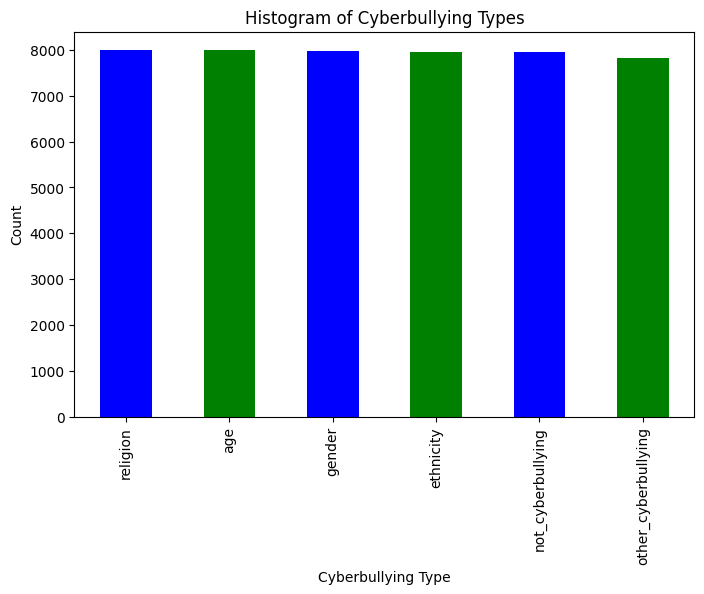

In [5]:
# Plotting the histogram
plt.figure(figsize=(8, 5))
df['cyberbullying_type'].value_counts().plot(kind='bar', color=['blue', 'green'])

plt.title('Histogram of Cyberbullying Types')
plt.xlabel('Cyberbullying Type')
plt.ylabel('Count')
plt.show()

In [6]:
# Print phrases 
for i, phrase in enumerate(df['tweet_text'][:15]):
    print(f"{i + 1}. {phrase}")

1. In other words #katandandre, your food was crapilicious! #mkr
2. Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc
3. @XochitlSuckkks a classy whore? Or more red velvet cupcakes?
4. @Jason_Gio meh. :P  thanks for the heads up, but not too concerned about another angry dude on twitter.
5. @RudhoeEnglish This is an ISIS account pretending to be a Kurdish account.  Like Islam, it is all lies.
6. @Raja5aab @Quickieleaks Yes, the test of god is that good or bad or indifferent or weird or whatever, it all proves gods existence.
7. Itu sekolah ya bukan tempat bully! Ga jauh kaya neraka
8. Karma. I hope it bites Kat on the butt. She is just nasty. #mkr
9. @stockputout everything but mostly my priest
10. Rebecca Black Drops Out of School Due to Bullying:
11. @Jord_Is_Dead http://t.co/UsQInYW5Gn
12. The Bully flushes on KD http://twitvid.com/A2TNP
13. Ughhhh #MKR
14. RT @Kurdsnews: Turkish state has killed 241 children in last 

# Preprocessing
- What about the links & Hashtag?